# Full vehicle model

In [ ]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go


## Drive cycle import

In [1074]:
# df_drivecycle = pd.read_excel(r'drive_cycles\drive_cycle_itr4.xlsx', sheet_name = 'itr4_avg')
# df_drivecycle = pd.read_excel(r'drive_cycles\Standard_DC.xlsx', sheet_name = 'SAE J2982')
df_drivecycle = pd.read_excel(r'drive_cycles\Standard_DC.xlsx', sheet_name = 'WMTC')

In [1075]:
df_drivecycle.columns

Index(['time_s', 'avg_speed_kmph', 'avg_accn_mps2'], dtype='object')

## Parameters

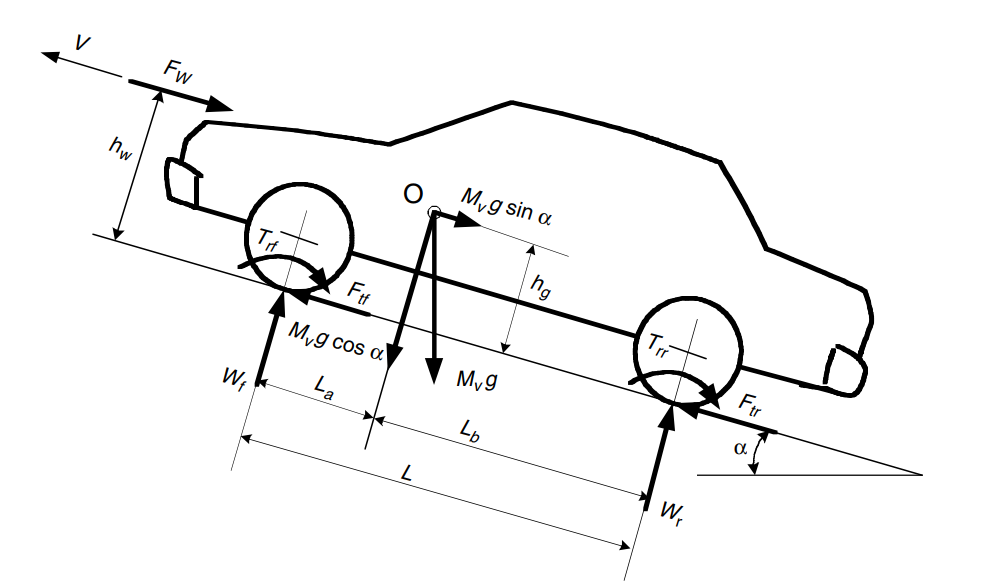

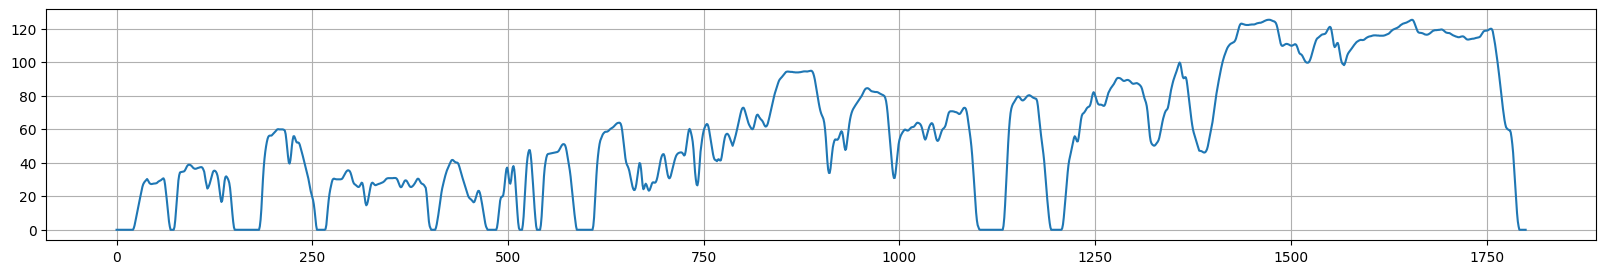

In [1076]:
plt.plot(df_drivecycle['time_s'], df_drivecycle['avg_speed_kmph'])
plt.grid()

### vehicle parameters (select - 0)

In [1077]:
vehicle_param = {'mass': 285, #kg
                 'g' : 9.81, #m/s^2 
                 'c_rr': 0.045,
                 'c_d': 0.58,
                 'f_area': 0.7, #m^2
                 'rho': 1.2, #kg/m^3
                 'gradient': 0, #deg
                 'v_air': 0, #tail wind in vehicle direction kmph
                 'wb' : 1.340, #m
                 'x_cg': .713, #m
                 'z_cg': .633, #m
                 'w_r' : 0.3, #m (average radius of front and rear wheel)
                 'i_whl' : 0.42, #kgm2 rolling inertia of wheel
                 'Eff_chain': 0.90,
                 'R_whl_gb': 3.294, # reduction ratio between gearbox and wheel
                 'i_gb' : 0.002, #kgm2
                 'Eff_gb' : 0.90,
                 'R_gb_mtr' : 1.676, # reduction ratio between gearbox and motor
                 'i_mtr' : 0.004 #kgm2
                 }


### coastdown parameters (select - 1)

In [1078]:
coastdown_param = {'mass': 285, #kg
                    'A' :50.9, #N
                    'B' :0, #N/kmph
                    'C' :0.025 #N/kmph^2
                   }

## Vehicle Force model

### Force Model

In [1079]:
veh0_coast1 = 1

In [1080]:
if veh0_coast1 == 0:
    # Fr = (0.01*(1+df_drivecycle['avg_speed_kmph'].to_numpy()/(3.6*100)))*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient'])) #for speed under 128kmph
    Fr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.cos(math.radians(vehicle_param['gradient']))
    Far = (0.5*vehicle_param['rho']*vehicle_param['f_area']*vehicle_param['c_d']/3.6**2)*(df_drivecycle['avg_speed_kmph'].to_numpy()+vehicle_param['v_air'])**2
    Fgr = vehicle_param['c_rr']*vehicle_param['mass']*vehicle_param['g']*math.sin(math.radians(vehicle_param['gradient']))
    Fac = vehicle_param['mass']*df_drivecycle['avg_accn_mps2'].to_numpy()
    Fr = Fr+Far+Fgr+Fac
    print('F_calc')
else:
    Fr = coastdown_param['A']
    Far = coastdown_param['C']*df_drivecycle['avg_speed_kmph']**2
    Fac = coastdown_param['mass']*df_drivecycle['avg_accn_mps2']
    Fb = coastdown_param['B']*df_drivecycle['avg_speed_kmph']
    Fr = Fr + Far + Fac + Fb
    print('F_coast')

F_coast


In [1081]:
# vel_arr = np.arange(0,140,10)
# Fa = coastdown_param['A']
# Far = coastdown_param['C']*vel_arr**2
#     # Fac = coastdown_param['mass']*df_drivecycle['avg_accn_mps2']
# Fb = coastdown_param['B']*vel_arr
# Fr = Fa + Far  + Fb

In [1082]:
# plt.plot(vel_arr, Fr)
# plt.grid()

### Roational resistance model

#### wheel

In [1083]:
Tr = Fr*vehicle_param['w_r'] #Nm

In [1084]:
Td_whl = Tr
# drive_Td_whl = np.clip(Tr, a_min = 0, a_max = None)
alpha_whl = df_drivecycle['avg_accn_mps2'].to_numpy()/vehicle_param['w_r']
torque_whl = alpha_whl * vehicle_param['i_whl']
itorque_whl = Td_whl + torque_whl
rpm_whl = ((df_drivecycle['avg_speed_kmph'].to_numpy()/3.6)/(2*math.pi*vehicle_param['w_r']))*60

#### gearbox

In [1085]:
T_gb = itorque_whl/(vehicle_param['R_whl_gb']*vehicle_param['Eff_chain'])
alpha_gb = alpha_whl * vehicle_param['R_whl_gb']
torque_gb = alpha_gb * vehicle_param['i_gb']
itorque_gb = T_gb + torque_gb
rpm_gb = rpm_whl * vehicle_param['R_whl_gb']

#### motor

In [1086]:
T_mtr = itorque_gb/(vehicle_param['R_gb_mtr']*vehicle_param['Eff_gb'])
alpha_mtr = alpha_gb * vehicle_param['R_gb_mtr']
torque_mtr = alpha_mtr * vehicle_param['i_mtr']
itorque_mtr = T_mtr + torque_mtr
rpm_mtr = rpm_gb * vehicle_param['R_gb_mtr']

#### drive forces

In [1087]:
drive_itorque_whl = np.clip(itorque_whl, a_min = 0, a_max = None)
drive_itorque_gb= np.clip(itorque_gb, a_min = 0, a_max = None)
drive_itorque_mtr = np.clip(itorque_mtr, a_min = 0, a_max = None)

#### braking forces

In [1088]:
brake_itorque_whl = np.clip(itorque_whl, a_min = None, a_max = 0)
# brake_itorque_whl = brake_itorque_whl[brake_itorque_whl != 0] 

brake_itorque_gb= np.clip(itorque_gb, a_min = None, a_max = 0)
# brake_itorque_gb = brake_itorque_gb[brake_itorque_gb != 0] 

brake_itorque_mtr = np.clip(itorque_mtr, a_min = None, a_max = 0)
# brake_itorque_mtr = brake_itorque_mtr[brake_itorque_mtr != 0] 

## Motor and Controller

### old efficiency

In [1089]:
mtr_eff_map = pd.read_csv(r"mtr_eff.csv", index_col = [0])
mtr_eff_arr = mtr_eff_map.values

In [1090]:
mtr_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_eff_dc.append(mtr_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_eff_dc = np.array(mtr_eff_dc)

In [1091]:
mtr_ctrl_eff_map = pd.read_csv(r"mtr_ctrl_eff.csv", index_col = [0])
mtr_ctrl_eff_arr = mtr_ctrl_eff_map.values

In [1092]:
mtr_ctrl_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    mtr_ctrl_eff_dc.append(mtr_ctrl_eff_arr[int(actual_rpm//100),int(actual_torque/10)])

mtr_ctrl_eff_dc = np.array(mtr_ctrl_eff_dc)

Text(0, 0.5, 'Efficiency %')

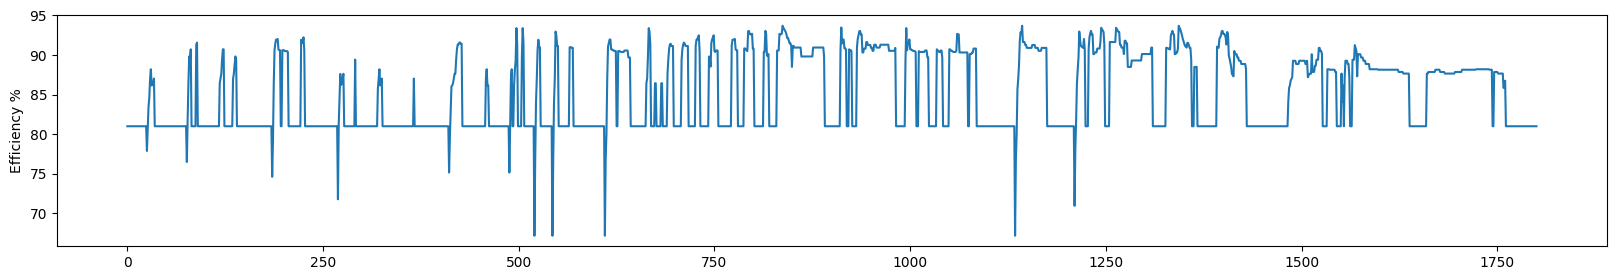

In [1093]:
total_mtr_system_eff_dc = mtr_ctrl_eff_dc * mtr_eff_dc/10000
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(total_mtr_system_eff_dc*100)
plt.ylabel("Efficiency %")

In [1094]:

fig1 = go.Figure(data=[go.Surface(z=mtr_eff_arr)])
fig1.update_layout(title='Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig1.show()

In [1095]:
fig2 = go.Figure(data=[go.Surface(z=mtr_ctrl_eff_arr)])

fig2.update_layout(title='Motor Controller Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig2.show()

In [634]:
fig5 = go.Figure(data=[go.Surface(z=((mtr_ctrl_eff_arr*mtr_eff_arr).transpose()))])

fig5.update_layout(title='Total Motor Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig5.show()

In [635]:
total_itorque_mtr = brake_itorque_mtr + drive_itorque_mtr
# plt.plot(total_itorque_mtr)
df_total_itorque_mtr  = pd.DataFrame()
df_total_itorque_mtr["drive_itorque_mtr"]= drive_itorque_mtr
df_total_itorque_mtr["total_itorque_mtr"] = total_itorque_mtr
df_total_itorque_mtr["rpm_mtr"] = rpm_mtr
df_total_itorque_mtr["total_mtr_system_eff_dc"] =   total_mtr_system_eff_dc
df_total_itorque_mtr["speed_kmph"] = df_drivecycle["avg_speed_kmph"]
df_total_itorque_mtr["time_s"] = df_drivecycle["time_s"]

# temp = df_total_itorque_mtr["total_mtr_system_eff_dc"]
df_total_itorque_mtr.loc[df_total_itorque_mtr["total_itorque_mtr"]<0,'total_mtr_system_eff_dc'] = np.nan


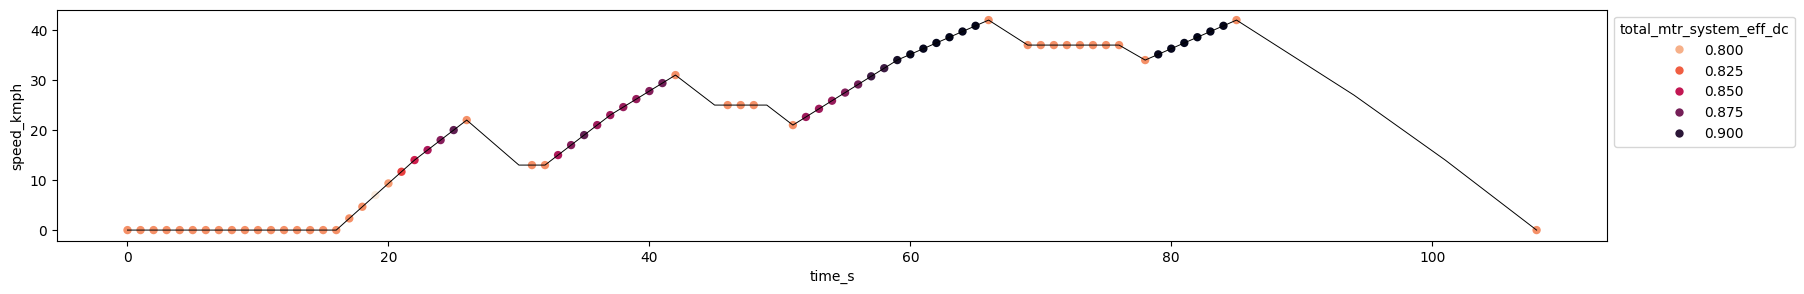

In [636]:
fig3 = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph",linewidth = 0.7, color = "black")
fig3 = sns.scatterplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", hue="total_mtr_system_eff_dc",  palette = "rocket_r", linewidth = 0 )
sns.move_legend(fig3, "upper left", bbox_to_anchor=(1, 1))


In [637]:
total_mtr_eff_arr = mtr_eff_arr* mtr_ctrl_eff_arr/10000
total_mtr_eff_arr= (total_mtr_eff_arr.transpose())[::-1]


C:\Users\Surya_Teja\AppData\Local\Temp\ipykernel_12608\1940627535.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



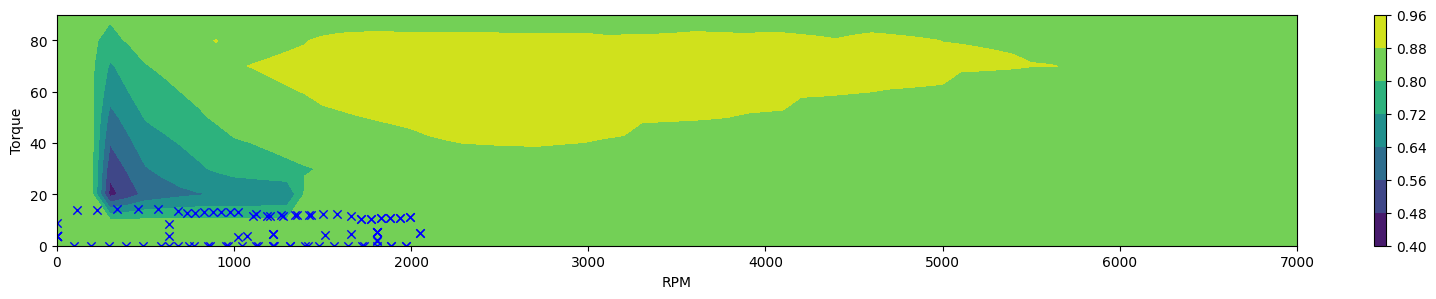

In [638]:
rpm = np.arange(0, 7100, 100)
torque = np.arange(0, 100, 10)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax.set_xlabel("RPM")
ax.set_ylabel("Torque")
# ax.legend().set_visible(False)
# ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
# ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
fig.show()

### sevcon eff

In [1130]:
sevcon_eff_map = pd.read_csv(r"sevcon_eff.csv", index_col = [0])
sevcon_eff_arr = sevcon_eff_map.values
sevcon_eff_arr[np.isnan(sevcon_eff_arr)] = 80
sevcon_eff_arr = sevcon_eff_arr*0.90

In [1131]:
fig5 = go.Figure(data=[go.Surface(z=((sevcon_eff_arr).transpose()))])

fig5.update_layout(title='SEVCON Efficiency', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig5.show()

In [1133]:
sevcon_eff_dc = []
for actual_torque, actual_rpm in zip(drive_itorque_mtr, rpm_mtr):
    sevcon_eff_dc.append(sevcon_eff_arr[int(actual_rpm//500),int(actual_torque/10)])

sevcon_eff_dc = np.array(sevcon_eff_dc)

In [1134]:
def apply_eff_map(actual_torque, actual_rpm, sevcon_eff_arr, rpm_bin_edges, torque_bin_edges):
    # Use numpy's searchsorted function to find the index of the bin edge for actual_rpm
    rpm_bin_indices = np.searchsorted(rpm_bin_edges, actual_rpm) - 1
    
    # Use numpy's searchsorted function to find the index of the bin edge for actual_torque
    torque_bin_indices = np.searchsorted(torque_bin_edges, actual_torque) - 1
    
    # Clip indices to ensure they are within valid range
    rpm_bin_indices = np.clip(rpm_bin_indices, 0, len(rpm_bin_edges) - 2)
    torque_bin_indices = np.clip(torque_bin_indices, 0, len(torque_bin_edges) - 2)

    # Create an array to store the binned values
    sevcon_eff_dc = sevcon_eff_arr[rpm_bin_indices, torque_bin_indices]

    return sevcon_eff_dc

In [1135]:
sevcon_eff_dc = apply_eff_map(drive_itorque_mtr,
rpm_mtr,sevcon_eff_arr,
sevcon_eff_map.index.to_numpy().astype(int),
sevcon_eff_map.columns.to_numpy().astype(int))

In [1136]:
total_mtr_system_eff_dc = sevcon_eff_dc/100

In [1137]:
total_itorque_mtr = brake_itorque_mtr + drive_itorque_mtr
# plt.plot(total_itorque_mtr)
df_total_itorque_mtr  = pd.DataFrame()
df_total_itorque_mtr["drive_itorque_mtr"]= drive_itorque_mtr
df_total_itorque_mtr["total_itorque_mtr"] = total_itorque_mtr
df_total_itorque_mtr["rpm_mtr"] = rpm_mtr
df_total_itorque_mtr["total_mtr_system_eff_dc"] =   total_mtr_system_eff_dc
df_total_itorque_mtr["speed_kmph"] = df_drivecycle["avg_speed_kmph"]
df_total_itorque_mtr["time_s"] = df_drivecycle["time_s"]

# temp = df_total_itorque_mtr["total_mtr_system_eff_dc"]
df_total_itorque_mtr.loc[df_total_itorque_mtr["total_itorque_mtr"]<0,'total_mtr_system_eff_dc'] = np.nan


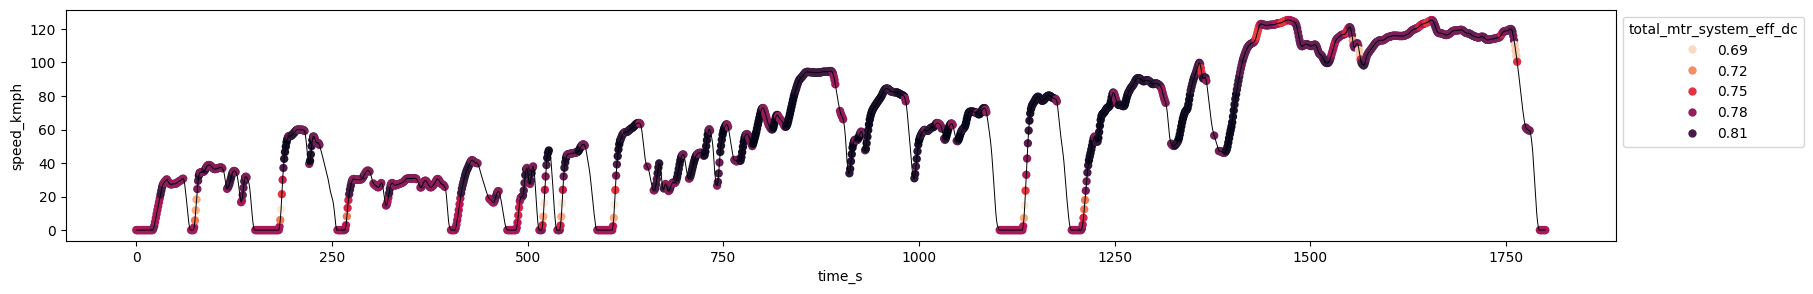

In [1138]:
fig3 = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph",linewidth = 0.7, color = "black")
fig3 = sns.scatterplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", hue="total_mtr_system_eff_dc",  palette = "rocket_r", linewidth = 0 )
sns.move_legend(fig3, "upper left", bbox_to_anchor=(1, 1))


In [1139]:
total_mtr_eff_arr = sevcon_eff_arr/100
total_mtr_eff_arr= (total_mtr_eff_arr.transpose())

Text(0, 0.5, 'Torque')

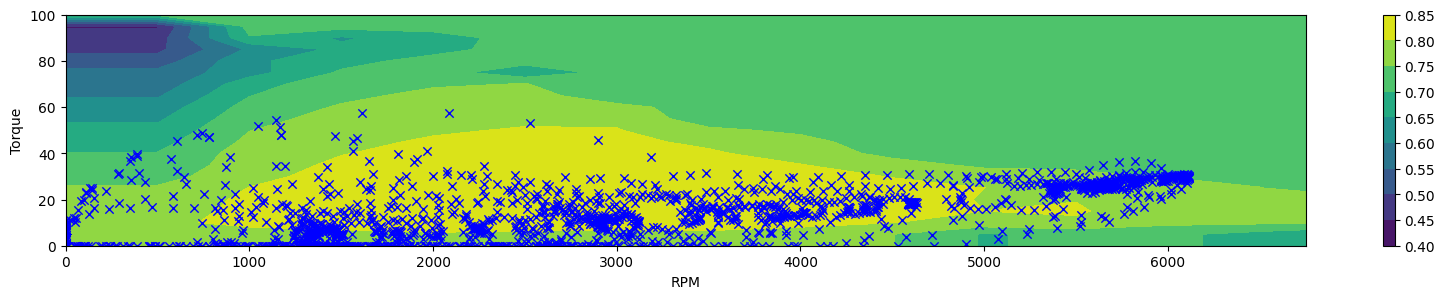

In [1140]:
rpm = sevcon_eff_map.index.to_numpy().astype(int)
torque = sevcon_eff_map.columns.to_numpy().astype(int)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax.set_xlabel("RPM")
ax.set_ylabel("Torque")
# ax.legend().set_visible(False)
# ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
# ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
# fig.show()

## Stats generation

In [1141]:
time = df_total_itorque_mtr['time_s']
speed = df_total_itorque_mtr['speed_kmph']
mtr_sys_eff = df_total_itorque_mtr['total_mtr_system_eff_dc']

In [1142]:
diff = [((speed[i+1]-speed[i-1])/3.6)/(time[i+1]-time[i-1]) for i in np.arange(1,len(time)-1)]
accn_mps2 = np.insert(diff,0,0)
accn_mps2 = np.append(accn_mps2,0)

### SAFD generation

In [1143]:
def safd_matrix(speed,accn_mps2,size):

    #bins
    bins_speed = np.round(np.arange(0,np.ceil(speed.max())+10,10).tolist(),2)
    bins_accn = np.round(np.arange(np.ceil(accn_mps2.min()*10)/10-0.1,np.ceil(accn_mps2.max()*10)/10+0.1,0.1).tolist(),2)

    speed_states = np.digitize(speed, bins_speed) - 1
    accn_states = np.digitize(accn_mps2, bins_accn) - 1

    df_states = pd.DataFrame()
    df_states['speed_states'] = speed_states
    df_states['accn_states'] = accn_states

    safd_matrix = np.zeros([len(bins_accn),len(bins_speed)])

    speed_lable = []
    for t in np.arange(len(bins_speed)-1):
        speed_lable.append(str(bins_speed[t])+'-'+str(bins_speed[t+1]))

    accn_lable = []
    for t in np.arange(len(bins_accn)-1):
        accn_lable.append(str(bins_accn[t])+'-'+str(bins_accn[t+1]))

    for i in range(len(bins_accn)):
        j = 0
        for j in range(len(bins_speed)):
            safd_matrix[i,j] = len(df_states[(df_states['speed_states'] == j)&(df_states['accn_states'] == i)])

    df_safd_matrix = pd.DataFrame(safd_matrix)
    df_safd_matrix.drop(df_safd_matrix.index[-1], inplace=True)
    df_safd_matrix.drop(df_safd_matrix.columns[-1], axis=1, inplace=True)

    fig,ax = plt.subplots(figsize=size)
    # heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto')
    heatmap = ax.imshow(df_safd_matrix.values, cmap = 'viridis',aspect='auto', vmax=500)
    ax.set_xticks(np.arange(len(speed_lable)))
    ax.set_yticks(np.arange(len(accn_lable)))
    ax.set_xticklabels(speed_lable)
    ax.set_yticklabels(accn_lable)
    for i in range(len(accn_lable)):
        for j in range(len(speed_lable)):
            text = ax.text(j, i, '{:.0f}'.format(safd_matrix[i, j]),
                        ha="center", va="center", color="w")

    cbar = plt.colorbar(heatmap)
    return df_safd_matrix

### power and energy

In [1144]:
import plotly.express as px

def energy_calc(time,speed,accn_mps2, mtr_sys_eff, coastdown_param):
    df_energy = pd.DataFrame()
    df_energy['time_s'] = time
    df_energy['speed_kmph'] = speed
    df_energy['accn_mps2'] = accn_mps2
    df_energy['dist_km'] = ((((df_energy['speed_kmph'].add(df_energy['speed_kmph'].shift(1)))/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    df_energy['Fr'] = coastdown_param['A'] + coastdown_param['C']*pow(df_energy['speed_kmph'],2) # a+cv^2 in N and v in kmph
    df_energy['Fa'] = coastdown_param['mass']*df_energy['accn_mps2'] # ma in N
    df_energy['Ft'] = df_energy['Fa'] + df_energy['Fr'] # total tractive effort in N

    # power
    df_energy['m_pwr_kW'] = (df_energy['Ft'] * df_energy['speed_kmph']/3.6)/1000 
    df_energy['e_pwr_kW'] = df_energy['m_pwr_kW'] / mtr_sys_eff

    # energy
    df_energy['m_energy_Wh'] = ((((df_energy['m_pwr_kW'].add(df_energy['m_pwr_kW'].shift(1)))*1000/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()
    df_energy['e_energy_Wh'] = ((((df_energy['e_pwr_kW'].add(df_energy['e_pwr_kW'].shift(1)))*1000/(2*3600))*(df_energy['time_s'] .sub(df_energy['time_s'] .shift(1)))).fillna(0)).cumsum()

    #Wh/km
    df_energy['m_Wh/km'] = ((df_energy['m_energy_Wh'])/df_energy['dist_km']).fillna(0)
    df_energy['e_Wh/km'] = ((df_energy['e_energy_Wh'])/df_energy['dist_km']).fillna(0)

    df_energy = df_energy.round(2)

    fig = px.line(df_energy,x = 'time_s',y = df_energy.columns)
    display(fig)
    return df_energy

In [1145]:
def stats(df_energy):
    stats = {}
    stats['total_time_s'] = df_energy['time_s'].max()
    stats['dist_km'] = df_energy['dist_km'].max()
    stats['max_speed_kmph'] = df_energy['speed_kmph'].max()
    stats['avg_speed_kmph'] = df_energy['speed_kmph'].mean().round(2)
    stats['max_positive_accn_mps2'] = df_energy['accn_mps2'].max()
    stats['max_negative_accn_mps2'] = df_energy['accn_mps2'].min()
    stats['rms_positive_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']>0,'accn_mps2'] ** 2)),2)
    stats['rms_negative_accn_mps2'] = round(np.sqrt(np.mean(df_energy.loc[df_energy['accn_mps2']<0,'accn_mps2'] ** 2)),2)
    stats['avg_m_power_kW'] = df_energy['m_pwr_kW'].mean().round(2)
    stats['avg_e_power_kW'] = df_energy['e_pwr_kW'].mean().round(2)
    stats['max_m_power_kW'] = df_energy['m_pwr_kW'].max()
    stats['max_e_power_kW'] = df_energy['e_pwr_kW'].max()
    stats['total_m_energy_Wh'] = df_energy['m_energy_Wh'].iloc[-1]
    stats['total_e_energy_Wh'] = df_energy['e_energy_Wh'].iloc[-1]
    stats['m_Wh/km'] = df_energy['m_Wh/km'].iloc[-1]
    stats['e_Wh/km'] = df_energy['e_Wh/km'].iloc[-1]
    # stats['energy_eff'] = round(stats['total_m_energy_Wh']/stats['total_e_energy_Wh'] * 100,2)
    stats['wh/km_eff'] = round(stats['m_Wh/km']/stats['e_Wh/km'] * 100,2)
    return stats

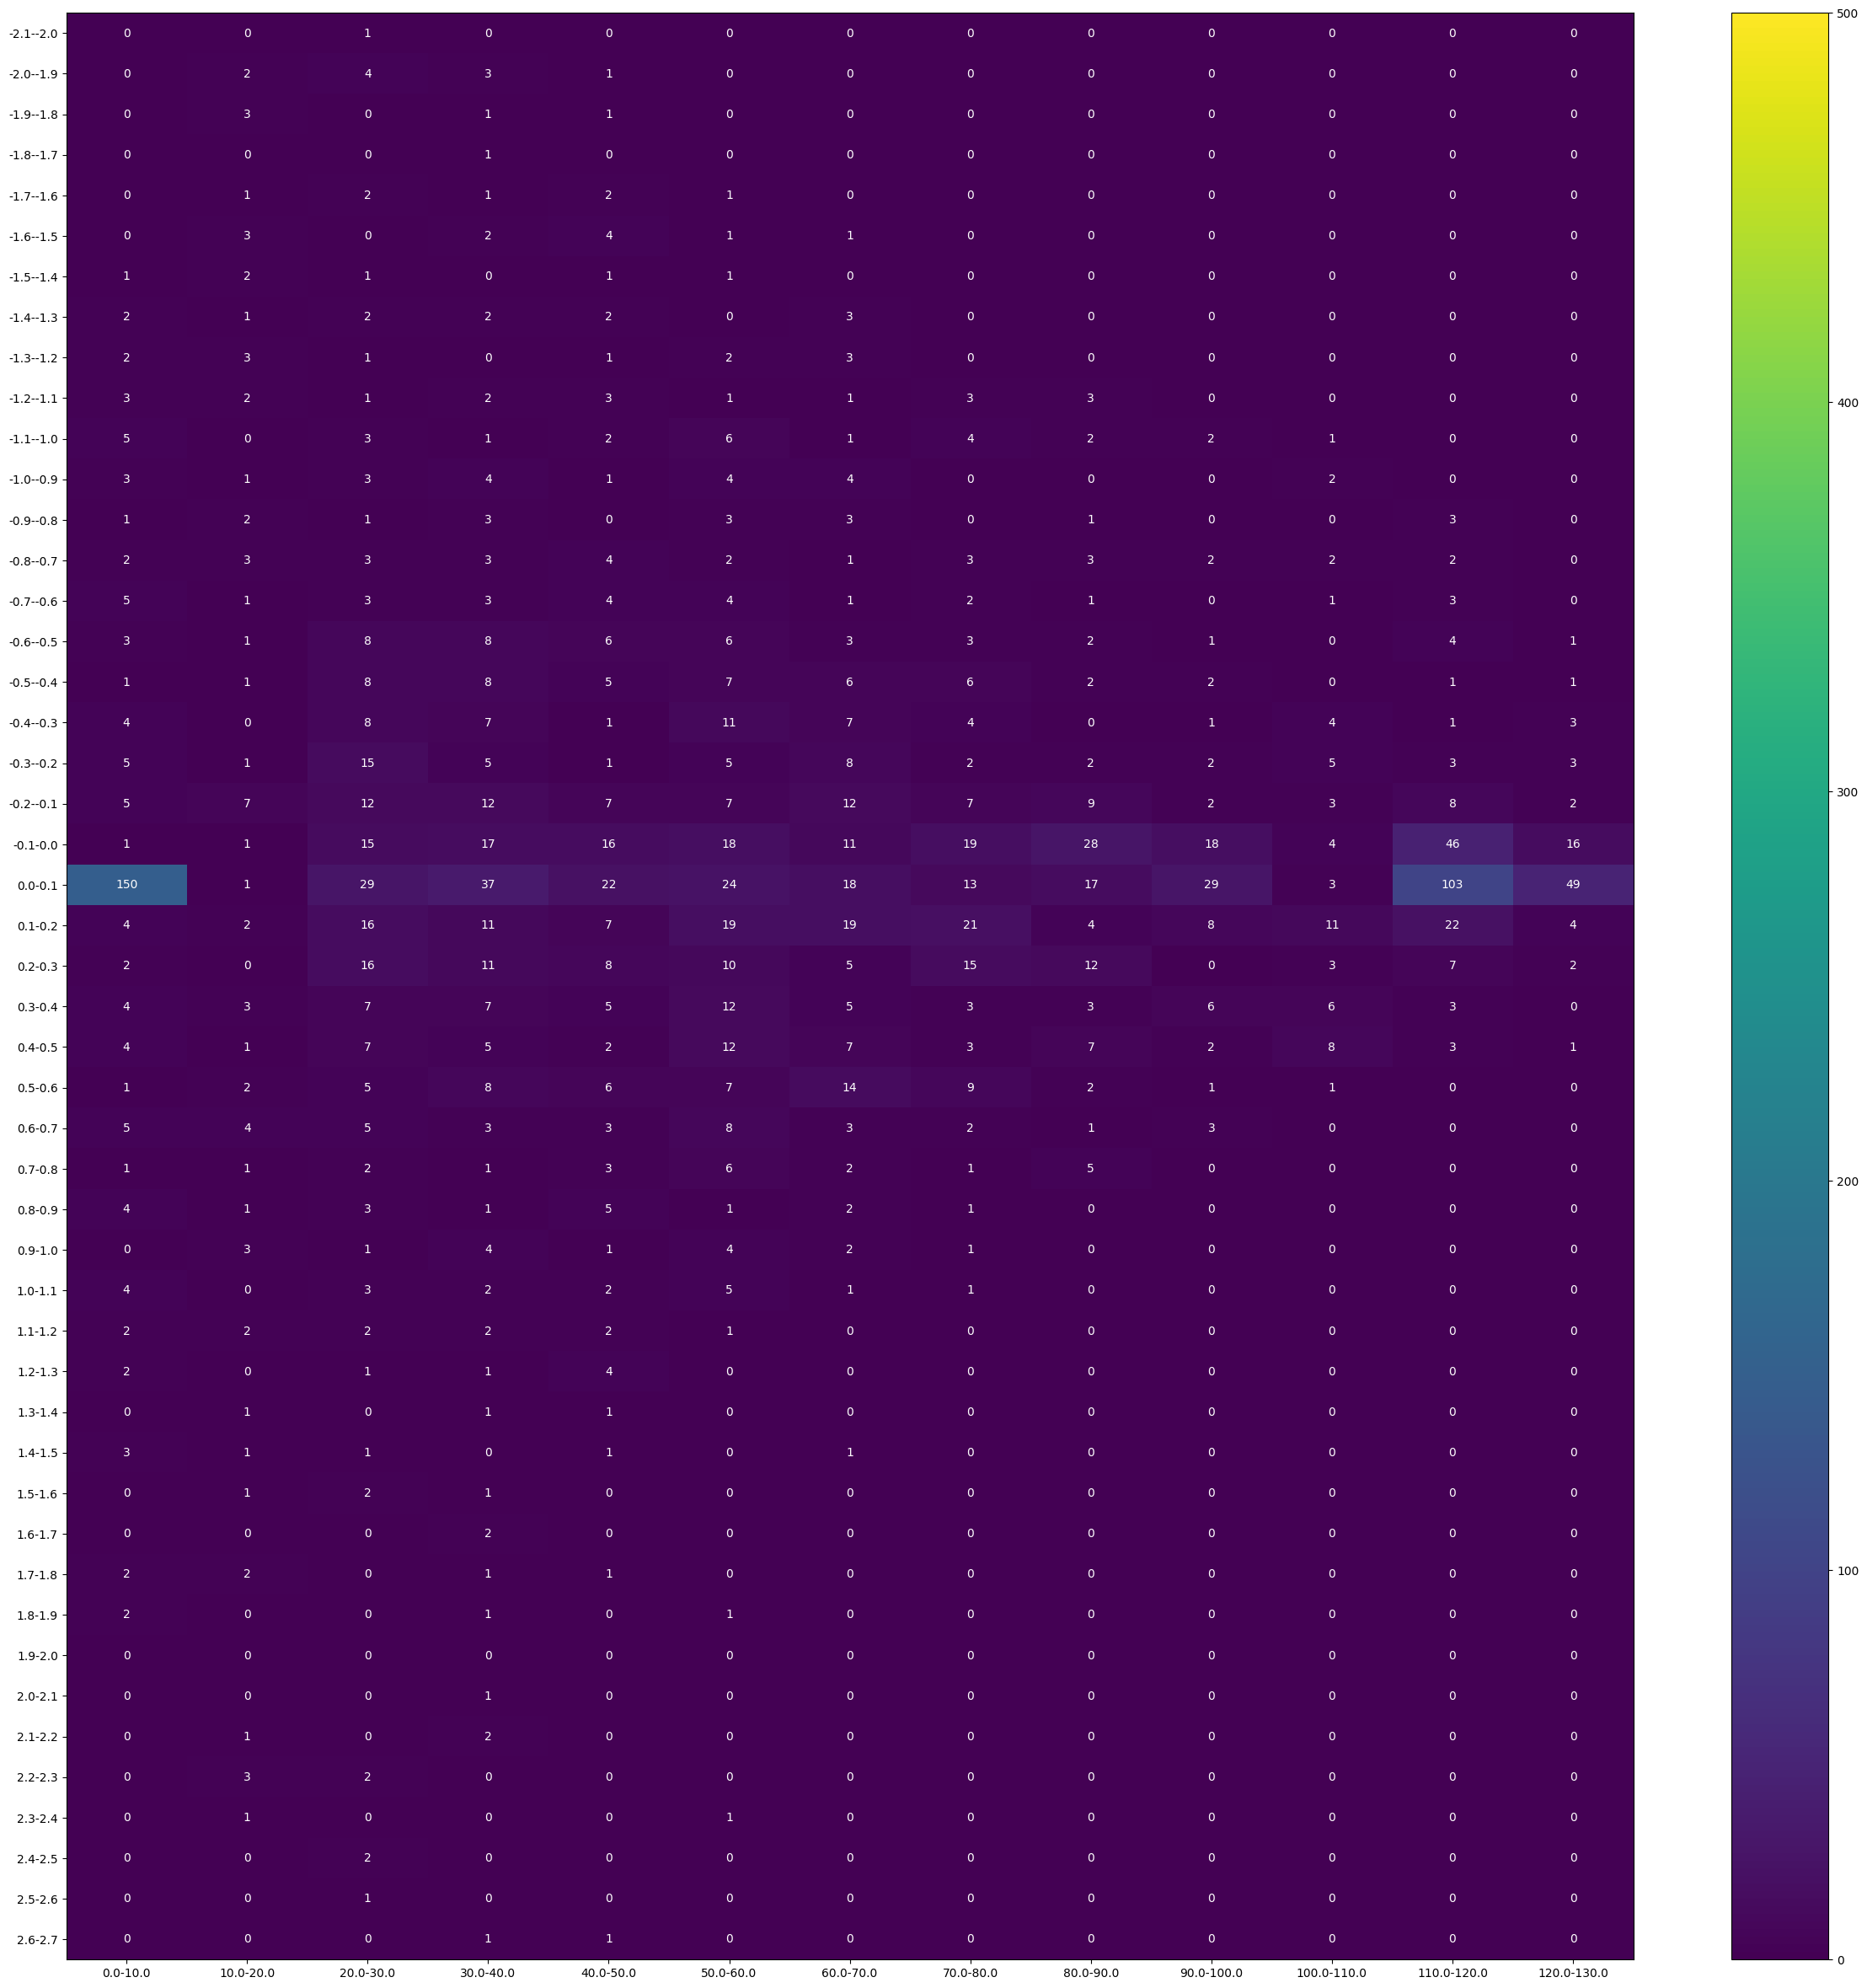

In [1146]:
df_safd_matrix = safd_matrix(speed,accn_mps2,[30,30])

In [1147]:
df_energy = energy_calc(time,speed,accn_mps2,mtr_sys_eff,coastdown_param)

In [1148]:
dc_stats = stats(df_energy)
for key in dc_stats:
    print(key, ' : ', dc_stats[key])

total_time_s  :  1800
dist_km  :  28.91
max_speed_kmph  :  125.3
avg_speed_kmph  :  57.79
max_positive_accn_mps2  :  2.67
max_negative_accn_mps2  :  -2.0
rms_positive_accn_mps2  :  0.58
rms_negative_accn_mps2  :  0.66
avg_m_power_kW  :  3.96
avg_e_power_kW  :  6.23
max_m_power_kW  :  18.07
max_e_power_kW  :  24.25
total_m_energy_Wh  :  1981.27
total_e_energy_Wh  :  2612.76
m_Wh/km  :  68.52
e_Wh/km  :  90.37
wh/km_eff  :  75.82


## Range Test Estimation 

In [1149]:
batt_cap = 10300 #wh

In [1150]:
# For High Range Vehicle, (1st 9 values of speed and then 9 values of torque percentage), Max torque value is 100Nm  and the percentages are wrt max torque
# Glide Mode = 0,500,1000,1500,2000,2500,3000,5000,7000,45,45,39,34,29,24,19,2,1
# Combat Mode = 0,979,1957,2936,3915,4893,5627,6950,7000,72,72,54,42,34,28,23,14,1
# Ballistic Mode = 0,1000,2000,2500,3000,4000,5000,6950,7000,86,86,86,86,86,86,86,27,1

In [1151]:
target_torque = df_total_itorque_mtr.drive_itorque_mtr
target_rpm = df_total_itorque_mtr.rpm_mtr

# Data for all drive modes
drive_modes = {
    "glide": {"rpm": [0, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7000], "trq": [45, 45, 39, 34, 29, 24, 19, 2, 1]},
    "combat": {"rpm": [0, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7000], "trq": [72, 72, 54, 42, 34, 28, 23, 14, 1]},
    "ballistic": {"rpm": [0, 500, 1000, 1500, 2000, 2500, 3000, 5000, 7000], "trq": [86, 86, 86, 86, 86, 86, 86, 27, 1]}
}

# Add a 5% buffer to the RPM values for all drive modes
buffer_percentage = 5

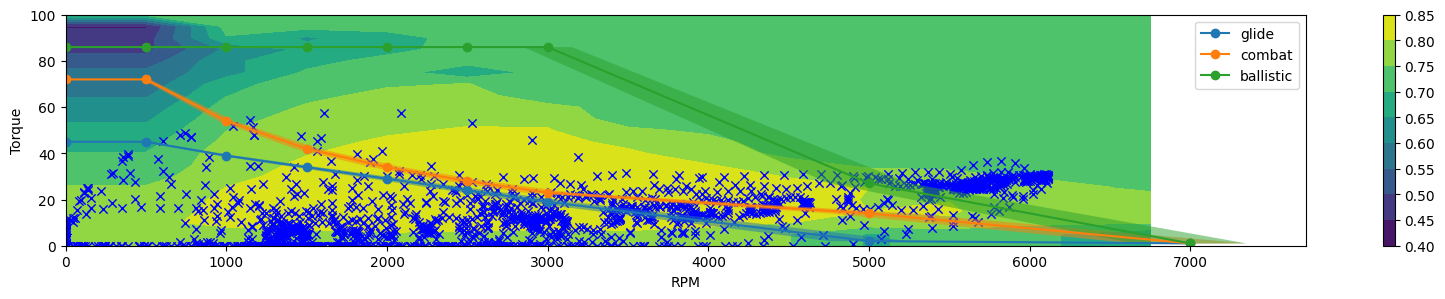

In [1152]:
rpm = sevcon_eff_map.index.to_numpy().astype(int)
torque = sevcon_eff_map.columns.to_numpy().astype(int)

[X, Y] = np.meshgrid(rpm, torque)  
Z = total_mtr_eff_arr

fig, ax = plt.subplots(1, 1)
cs = ax.contourf(X, Y, Z)
cbar = fig.colorbar(cs)
# ax = sns.scatterplot(data=df_total_itorque_mtr, x="rpm_mtr", y="drive_itorque_mtr", color = "blue", linewidth = 1, marker= "x")
ax = sns.scatterplot(x=target_rpm, y=target_torque, color = "blue", linewidth = 1, marker= "x")
# for drive_mode, data in buffered_drive_modes.items():
#     ax.plot(data['rpm'], data['trq'], label=drive_mode, marker='o')
for drive_mode, data in drive_modes.items():
    # ax = sns.lineplot(x=data['rpm'], y=data['trq'], label=drive_mode, marker='o',  err_style="bars", errorbar=("sd"))
    xerr = buffer_percentage/100 * np.array(data['rpm'])  # 5% error on x-axis
    ax.plot(data['rpm'], data['trq'], label=drive_mode, marker='o')
    ax.fill_betweenx(data['trq'], np.array(data['rpm']) - xerr, np.array(data['rpm']) + xerr, alpha=0.5)

ax.set_xlabel("RPM")
ax.set_ylabel("Torque")

ax.legend()
# ax.set_xlim(0,max(df_total_itorque_mtr["rpm_mtr"])+100)
# ax.set_ylim(0,max(df_total_itorque_mtr["drive_itorque_mtr"])+5)
# fig.show()

In [1153]:
buffered_drive_modes = {}

for mode, data in drive_modes.items():
    buffered_rpm = [rpm * (1 + buffer_percentage / 100) for rpm in data['rpm']]
    buffered_drive_modes[mode] = {'rpm': buffered_rpm, 'trq': data['trq']}
    
# Interpolate to find the max torque for each target RPM in each drive mode
max_torques = {
    mode: np.interp(target_rpm, data['rpm'], data['trq'])
    for mode, data in buffered_drive_modes.items()
}

# batt_util if given torque and RPM arrays are under the max torques
overall_checks = {
    mode: np.all(target_torque <= max_torque_at_target_rpm)
    for mode, max_torque_at_target_rpm in max_torques.items()
}

# Assign batt_util variable based on conditions
batt_util = 0
if overall_checks["glide"] and overall_checks["combat"] and overall_checks["ballistic"]:
    batt_util = 1
elif overall_checks["combat"] and overall_checks["ballistic"]:
    batt_util = .8
elif overall_checks["ballistic"]:
    batt_util = .7

# Output the results
print(f"For Mode check:")
print(f"    Mode Checks: {overall_checks}")
print(f"    Battery Utilisation: {batt_util*100} %")
print(f"    Mechanical Wh/km: {dc_stats['m_Wh/km']}")
print(f"    Electrical Wh/km: {dc_stats['e_Wh/km']}")
print(f"    Efficiency: {dc_stats['wh/km_eff']} %")
print(f"    Range Covered: {np.round(batt_cap*batt_util/dc_stats['e_Wh/km'],2)} km")

For Mode check:
    Mode Checks: {'glide': False, 'combat': False, 'ballistic': False}
    Battery Utilisation: 0 %
    Mechanical Wh/km: 68.52
    Electrical Wh/km: 90.37
    Efficiency: 75.82 %
    Range Covered: 0.0 km


In [1154]:
mode_max_trq = pd.DataFrame()
for mode, data in max_torques.items():
    mode_max_trq[f'{mode}_trq_max'] = max_torques[f'{mode}']

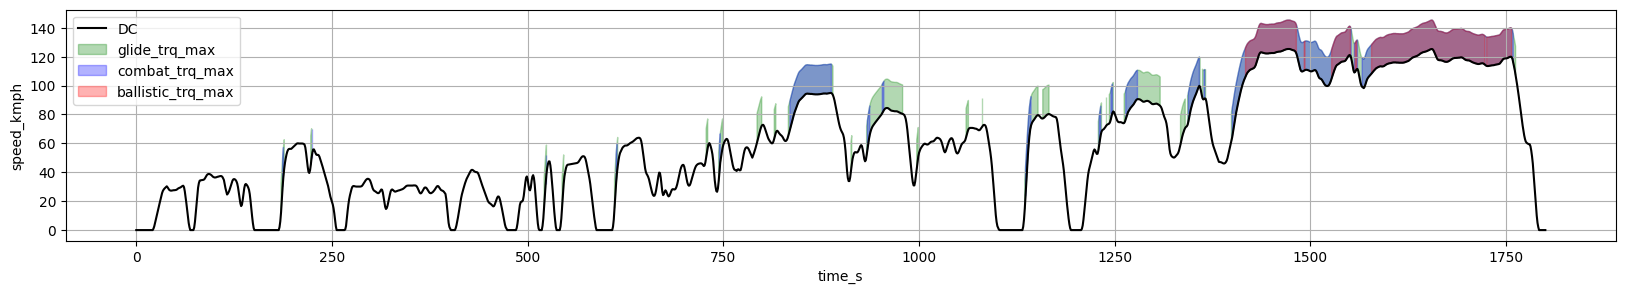

In [1156]:
# Example DataFrame
data = {'Column1': [1, 3, 4, 2, 6, 8, 5, 7],
        'Column2': [2, 4, 3, 5, 7, 9, 6, 8]}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots()

# Plot Column1 as a line
ax = sns.lineplot(data=df_total_itorque_mtr, x="time_s", y="speed_kmph", color = "black", label = "DC")

colors = ['green', 'blue', 'red']

for i, col in enumerate(mode_max_trq.columns):
        ax.fill_between(df_total_itorque_mtr['time_s'],df_total_itorque_mtr['speed_kmph'], df_total_itorque_mtr['speed_kmph']+20, where=df_total_itorque_mtr['drive_itorque_mtr'] > mode_max_trq[col], color=colors[i], alpha=0.3, label=f'{col}')

# # Add legend
ax.legend()
ax.grid()
# # Show the plot
# plt.show()
